# Gather image files and their categories

In [7]:
from pathlib import Path
import random
import pandas as pd
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

def set_seed(seed_value=42):
    random.seed(seed_value)
    torch.manual_seed(seed_value)

set_seed()

def collect_images(dataset_root="Aerial_Landscapes"):
    valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
    img_collection = []
    
    root_path = Path(dataset_root)
    for category_folder in root_path.iterdir():
        if category_folder.is_dir():
            category = category_folder.name
            img_collection.extend(
                (str(img_file), category)
                for img_file in category_folder.iterdir()
                if img_file.suffix.lower() in valid_extensions
            )

    for img_path, category in img_collection[:5]:
        print(f"Found image: {img_path} | Category: {category}")
    
    return img_collection

image_list = collect_images()

Found image: Aerial_Landscapes\Agriculture\001.jpg | Category: Agriculture
Found image: Aerial_Landscapes\Agriculture\002.jpg | Category: Agriculture
Found image: Aerial_Landscapes\Agriculture\003.jpg | Category: Agriculture
Found image: Aerial_Landscapes\Agriculture\004.jpg | Category: Agriculture
Found image: Aerial_Landscapes\Agriculture\005.jpg | Category: Agriculture


# Convert category names to numeric IDs

In [10]:
def assign_numeric_labels(images):
    class_names = [
        "Agriculture", "Airport", "Beach", "City", "Desert",
        "Forest", "Grassland", "Highway", "Lake", "Mountain",
        "Parking", "Port", "Railway", "Residential", "River"
    ]
    category_to_numeric = {name: index for index, name in enumerate(class_names)}
    
    labeled_images = [(path, category_to_numeric[cat]) for path, cat in images]
    
    # Show sample mappings
    for path, num_label in labeled_images[:5]:
        print(f"Image: {path} | Numeric Label: {num_label}")
    
    return labeled_images, class_names

labeled_images, class_names = assign_numeric_labels(image_list)

Image: Aerial_Landscapes\Agriculture\001.jpg | Numeric Label: 0
Image: Aerial_Landscapes\Agriculture\002.jpg | Numeric Label: 0
Image: Aerial_Landscapes\Agriculture\003.jpg | Numeric Label: 0
Image: Aerial_Landscapes\Agriculture\004.jpg | Numeric Label: 0
Image: Aerial_Landscapes\Agriculture\005.jpg | Numeric Label: 0


# Split into training and validation sets with stratification

In [13]:
def split_dataset(image_data, train_ratio=0.8):
    images_by_class = defaultdict(list)
    for img_path, label_id in image_data:
        images_by_class[label_id].append(img_path)

    print("Class Distribution:")
    for cls_id in sorted(images_by_class):
        print(f"Class {cls_id} ({class_names[cls_id]}): {len(images_by_class[cls_id])} images")
    
    train_set, val_set = [], []
    for cls_id, img_paths in images_by_class.items():
        random.shuffle(img_paths)
        split_point = max(1, int(train_ratio * len(img_paths)))
        if split_point == len(img_paths):
            split_point -= 1
        train_set.extend((img, cls_id) for img in img_paths[:split_point])
        val_set.extend((img, cls_id) for img in img_paths[split_point:])

    train_counts = defaultdict(int)
    val_counts = defaultdict(int)
    for _, cls_id in train_set:
        train_counts[cls_id] += 1
    for _, cls_id in val_set:
        val_counts[cls_id] += 1
    
    print("\nTraining Set Distribution:")
    for cls_id in sorted(train_counts):
        print(f"Class {cls_id} ({class_names[cls_id]}): {train_counts[cls_id]} images")
    
    print("\nValidation Set Distribution:")
    for cls_id in sorted(val_counts):
        print(f"Class {cls_id} ({class_names[cls_id]}): {val_counts[cls_id]} images")
    
    return train_set, val_set

train_samples, val_samples = split_dataset(labeled_images)

Class Distribution:
Class 0 (Agriculture): 800 images
Class 1 (Airport): 800 images
Class 2 (Beach): 800 images
Class 3 (City): 800 images
Class 4 (Desert): 800 images
Class 5 (Forest): 800 images
Class 6 (Grassland): 800 images
Class 7 (Highway): 800 images
Class 8 (Lake): 800 images
Class 9 (Mountain): 800 images
Class 10 (Parking): 800 images
Class 11 (Port): 800 images
Class 12 (Railway): 800 images
Class 13 (Residential): 800 images
Class 14 (River): 800 images

Training Set Distribution:
Class 0 (Agriculture): 640 images
Class 1 (Airport): 640 images
Class 2 (Beach): 640 images
Class 3 (City): 640 images
Class 4 (Desert): 640 images
Class 5 (Forest): 640 images
Class 6 (Grassland): 640 images
Class 7 (Highway): 640 images
Class 8 (Lake): 640 images
Class 9 (Mountain): 640 images
Class 10 (Parking): 640 images
Class 11 (Port): 640 images
Class 12 (Railway): 640 images
Class 13 (Residential): 640 images
Class 14 (River): 640 images

Validation Set Distribution:
Class 0 (Agriculture

# Subset dataset with stratified sampling

In [16]:
def subsample_stratified(data_subset, target_count):
    class_samples = defaultdict(list)
    for sample in data_subset:
        class_samples[sample[1]].append(sample)
    
    sampled_data = []
    total_samples = len(data_subset)
    
    for cls_id, samples in class_samples.items():
        proportion = len(samples) / total_samples
        sample_size = max(1, int(proportion * target_count))
        random.shuffle(samples)
        sampled_data.extend(samples[:sample_size])
    
    # Adjust to exact target count
    if len(sampled_data) < target_count:
        remaining = target_count - len(sampled_data)
        unused_samples = []
        for cls_id, samples in class_samples.items():
            used = set(tuple(s) for s in sampled_data if s[1] == cls_id)
            unused_samples.extend(s for s in samples if tuple(s) not in used)
        random.shuffle(unused_samples)
        sampled_data.extend(unused_samples[:remaining])
    elif len(sampled_data) > target_count:
        random.shuffle(sampled_data)
        sampled_data = sampled_data[:target_count]
    
    return sampled_data

train_samples = subsample_stratified(train_samples, 960)
val_samples = subsample_stratified(val_samples, 240)

train_dist = defaultdict(int)
val_dist = defaultdict(int)
for _, cls_id in train_samples:
    train_dist[cls_id] += 1
for _, cls_id in val_samples:
    val_dist[cls_id] += 1

print("\nFinal Training Distribution:")
for cls_id in sorted(train_dist):
    print(f"Class {cls_id} ({class_names[cls_id]}): {train_dist[cls_id]} images")

print("\nFinal Validation Distribution:")
for cls_id in sorted(val_dist):
    print(f"Class {cls_id} ({class_names[cls_id]}): {val_dist[cls_id]} images")


Final Training Distribution:
Class 0 (Agriculture): 64 images
Class 1 (Airport): 64 images
Class 2 (Beach): 64 images
Class 3 (City): 64 images
Class 4 (Desert): 64 images
Class 5 (Forest): 64 images
Class 6 (Grassland): 64 images
Class 7 (Highway): 64 images
Class 8 (Lake): 64 images
Class 9 (Mountain): 64 images
Class 10 (Parking): 64 images
Class 11 (Port): 64 images
Class 12 (Railway): 64 images
Class 13 (Residential): 64 images
Class 14 (River): 64 images

Final Validation Distribution:
Class 0 (Agriculture): 16 images
Class 1 (Airport): 16 images
Class 2 (Beach): 16 images
Class 3 (City): 16 images
Class 4 (Desert): 16 images
Class 5 (Forest): 16 images
Class 6 (Grassland): 16 images
Class 7 (Highway): 16 images
Class 8 (Lake): 16 images
Class 9 (Mountain): 16 images
Class 10 (Parking): 16 images
Class 11 (Port): 16 images
Class 12 (Railway): 16 images
Class 13 (Residential): 16 images
Class 14 (River): 16 images


# Define a custom dataset for remote sensing images

In [19]:
class AerialImageDataset(Dataset):
    def __init__(self, samples, preprocessing=None):
        self.samples = samples
        self.preprocessing = preprocessing
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        img_path, label = self.samples[index]
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as err:
            print(f"Failed to load {img_path}: {err}")
            img = Image.new("RGB", (224, 224), (0, 0, 0))
        
        if self.preprocessing:
            img = self.preprocessing(img)
        
        return img, label

# Prepare data loaders with image transformations

In [22]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])
])

train_dataset = AerialImageDataset(train_samples, preprocessing=image_transforms)
val_dataset = AerialImageDataset(val_samples, preprocessing=image_transforms)

print(f"Training dataset contains {len(train_dataset)} samples")
print(f"Validation dataset contains {len(val_dataset)} samples")

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

# Check a batch
for batch_idx, (imgs, lbls) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}: Images shape {imgs.shape}, Labels shape {lbls.shape}")
    break

Training dataset contains 960 samples
Validation dataset contains 240 samples
Batch 1: Images shape torch.Size([4, 3, 224, 224]), Labels shape torch.Size([4])


# Prepare DenseNet121 model

In [25]:
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computing on: {computing_device}")

densenet_model = models.densenet121(weights="IMAGENET1K_V1")
print("DenseNet121 initialized")
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 15)
print("Output layer adjusted")
densenet_model = densenet_model.to(computing_device)
print("Model transferred to device")

Computing on: cpu
DenseNet121 initialized
Output layer adjusted
Model transferred to device


# Set the optimizer, loss function and train

In [28]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=1e-4)
training_epochs = 5

# Training loop
for epoch in range(training_epochs):
    densenet_model.train()
    cumulative_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    print(f"Epoch {epoch + 1} started")
    
    for batch_imgs, batch_labels in train_dataloader:
        batch_imgs = batch_imgs.to(computing_device)
        batch_labels = batch_labels.to(computing_device)
        
        optimizer.zero_grad()
        predictions = densenet_model(batch_imgs)
        loss = loss_function(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        
        cumulative_loss += loss.item()
        _, predicted_classes = predictions.max(1)
        correct_predictions += (predicted_classes == batch_labels).sum().item()
        total_samples += batch_labels.size(0)
    
    avg_loss = cumulative_loss / len(train_dataloader)
    accuracy = 100 * correct_predictions / total_samples
    print(f"Epoch {epoch + 1}/{training_epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")

# Save the trained model
torch.save(densenet_model.state_dict(), "densenet121_aerial_classifier.pth")
print("Model weights saved")

Epoch 1 started
Epoch 1/5 | Loss: 1.7299 | Accuracy: 51.77%
Epoch 2 started
Epoch 2/5 | Loss: 0.8485 | Accuracy: 79.79%
Epoch 3 started
Epoch 3/5 | Loss: 0.5534 | Accuracy: 87.50%
Epoch 4 started
Epoch 4/5 | Loss: 0.4111 | Accuracy: 90.83%
Epoch 5 started
Epoch 5/5 | Loss: 0.2524 | Accuracy: 95.21%
Model weights saved


# Evaluate the model

In [30]:
densenet_model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for batch_imgs, batch_labels in val_dataloader:
        batch_imgs = batch_imgs.to(computing_device)
        batch_labels = batch_labels.to(computing_device)
        outputs = densenet_model(batch_imgs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        ground_truth.extend(batch_labels.cpu().numpy())

# Display label distributions
from collections import Counter
print("Ground Truth Distribution:", Counter(ground_truth))
print("Predicted Distribution:", Counter(predictions))
print("********************************************")
# Compute metrics
print("Precision:", precision_score(ground_truth, predictions, average="macro"))
print("Recall:", recall_score(ground_truth, predictions, average="macro"))
print("F1 Score:", f1_score(ground_truth, predictions, average="macro"))
print("\nDetailed Classification Metrics:")
print(classification_report(ground_truth, predictions, target_names=class_names))
print("********************************************")

#implyment confusion_matrix
cm = confusion_matrix(ground_truth, predictions)
class_names = [
    "Agriculture", "Airport", "Beach", "City", "Desert",
    "Forest", "Grassland", "Highway", "Lake", "Mountain",
    "Parking", "Port", "Railway", "Residential", "River"
]
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

pd.set_option('display.width', 1000) 
pd.set_option('display.max_columns', 20) 
pd.set_option('display.expand_frame_repr', False)

print("Confusion Matrix:")
print(cm_df)
print("********************************************")

Ground Truth Distribution: Counter({0: 16, 1: 16, 2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 16, 8: 16, 9: 16, 10: 16, 11: 16, 12: 16, 13: 16, 14: 16})
Predicted Distribution: Counter({6: 19, 1: 18, 11: 17, 9: 17, 12: 17, 7: 17, 0: 16, 2: 16, 13: 16, 5: 16, 8: 15, 10: 15, 3: 14, 4: 14, 14: 13})
********************************************
Precision: 0.9109763536543725
Recall: 0.9083333333333333
F1 Score: 0.9075323235439048

Detailed Classification Metrics:
              precision    recall  f1-score   support

 Agriculture       1.00      1.00      1.00        16
     Airport       0.89      1.00      0.94        16
       Beach       0.94      0.94      0.94        16
        City       1.00      0.88      0.93        16
      Desert       0.86      0.75      0.80        16
      Forest       1.00      1.00      1.00        16
   Grassland       0.84      1.00      0.91        16
     Highway       0.88      0.94      0.91        16
        Lake       0.87      0.81      0.84        16
   

# Implement Grad-CAM

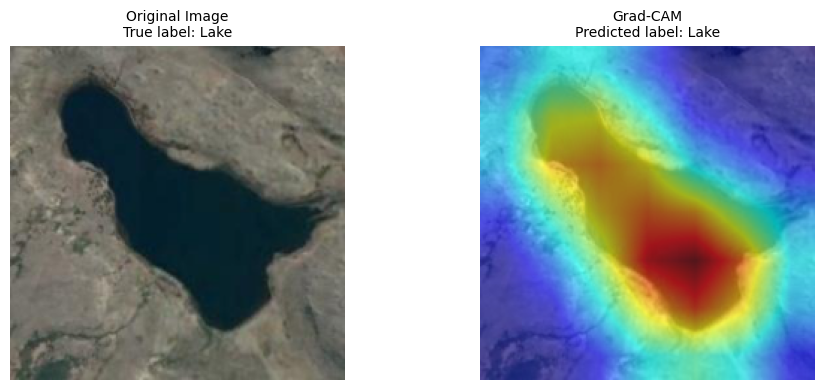

In [46]:
from torchvision.transforms.functional import to_pil_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch
import numpy as np

class_names = [
    "Agriculture", "Airport", "Beach", "City", "Desert",
    "Forest", "Grassland", "Highway", "Lake", "Mountain",
    "Parking", "Port", "Railway", "Residential", "River"
]

sample_img, sample_label = val_dataset[128] 
input_tensor = sample_img.unsqueeze(0).to(computing_device)

densenet_model.eval()
with torch.no_grad():
    output = densenet_model(input_tensor)
    predicted = output.argmax(dim=1).item()

target_layers = [densenet_model.features[-1]] 
with GradCAM(model=densenet_model, target_layers=target_layers) as cam:
    targets = [ClassifierOutputTarget(predicted)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

def denormalize_img(t):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.2, 0.2, 0.2]).view(3, 1, 1)
    t = t.cpu()  
    denormed = t * std + mean  
    denormed = torch.clamp(denormed, 0, 1) 
    return denormed.numpy().transpose(1, 2, 0)  

rgb_img = denormalize_img(sample_img)

denormed_tensor = torch.from_numpy(rgb_img.transpose(2, 0, 1)) 
image_pil = to_pil_image(denormed_tensor)

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image_pil)
axes[0].axis('off')
axes[0].set_title(f"Original Image\nTrue label: {class_names[sample_label]}", fontsize=10)

axes[1].imshow(visualization)
axes[1].axis('off')
axes[1].set_title(f"Grad-CAM\nPredicted label: {class_names[predicted]}", fontsize=10)

plt.tight_layout()
plt.show()